In [306]:
# Importing the necessary modules
# For basic data manipulation
import pandas as pd
import numpy as np

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from warnings import filterwarnings
filterwarnings('ignore')

# For manipulating dates
import datetime as dt

# All the alogorithms used
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBRegressor, XGBClassifier

# Metrics and scores
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine, correlation

In [307]:
# Importing the data
customer= pd.read_excel('CustomersData.xlsx')
discount= pd.read_csv('Discount_Coupon.csv')
marketing= pd.read_csv('Marketing_Spend.csv')
sales= pd.read_csv('Online_Sales.csv')
tax= pd.read_excel('Tax_amount.xlsx')

In [308]:
customer.head(2)

,CustomerID,Gender,Location,Tenure_Months
0,17850,M,Chicago,12
1,13047,M,California,43


In [309]:
discount.head(2)

,Month,Product_Category,Coupon_Code,Discount_pct
0,Jan,Apparel,SALE10,10
1,Feb,Apparel,SALE20,20


In [310]:
marketing.head(2)

,Date,Offline_Spend,Online_Spend
0,1/1/2019,4500,2424.50
1,1/2/2019,4500,3480.36


In [311]:
sales.head(2)

,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status
0,17850,16679,20190101,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used
1,17850,16680,20190101,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used


In [312]:
tax.head(2)

,Product_Category,GST
0,Nest-USA,0.1
1,Office,0.1


In [313]:
# Removing the outer spaces from column names
customer.columns= customer.columns.str.strip()
discount.columns= discount.columns.str.strip()
marketing.columns= marketing.columns.str.strip()
sales.columns= sales.columns.str.strip()
tax.columns= tax.columns.str.strip()

sales['Product_Category']= sales['Product_Category'].astype('str')
discount['Product_Category']= discount['Product_Category'].astype('str')


print('Customer shape:',customer.shape)
print('discount shape:',discount.shape)
print('marketing shape:',marketing.shape)
print('sales shape:',sales.shape)
print('tax shape:',tax.shape)

Customer shape: (1468, 4)
discount shape: (204, 4)
marketing shape: (365, 3)
sales shape: (52924, 10)
tax shape: (20, 2)


In [314]:
# Extracting Transaction date from the string date, then extracting month from it.
sales['Transaction_Date']=sales['Transaction_Date'].astype('str').str[0:4]+'-'+sales['Transaction_Date'].astype('str').str[4:6]+'-'+sales['Transaction_Date'].astype('str').str[6:]
sales['Transaction_Date']=sales['Transaction_Date'].astype('datetime64')
sales['Month']= sales['Transaction_Date'].dt.month

In [315]:
# Changing type of month column from month name to month number
discount['Month']=pd.to_datetime(discount['Month'], format='%b')
discount['Month']=discount['Month'].dt.month
marketing['Date']= marketing.Date.astype('Datetime64')

In [316]:
# Combining online and offline marketing spend in one
marketing['Total_marketing_spend']= marketing['Offline_Spend']+marketing['Online_Spend']

In [317]:
# Joining discont and customer info in sales table
sales= sales.merge(discount, on=['Product_Category','Month'], how='left').merge(tax, on='Product_Category', how='left')
sales= sales.merge(customer, on=['CustomerID'], how='left')
sales= sales.merge(marketing, left_on='Transaction_Date', right_on='Date', how='left')
# sales= sales.merge(tax, on='Product_Category', how='inner')
sales.shape

(52924, 21)

In [318]:
sales.isna().sum()

CustomerID                 0
Transaction_ID             0
Transaction_Date           0
Product_SKU                0
Product_Description        0
Product_Category           0
Quantity                   0
Avg_Price                  0
Delivery_Charges           0
Coupon_Status              0
Month                      0
Coupon_Code              400
Discount_pct             400
GST                        0
Gender                     0
Location                   0
Tenure_Months              0
Date                       0
Offline_Spend              0
Online_Spend               0
Total_marketing_spend      0
dtype: int64

In [319]:
# Extracting week and day names from date
sales['week']= sales['Transaction_Date'].dt.weekofyear
sales['day']= sales['Transaction_Date'].dt.day_name()

# 1. Calculate Invoice amount or sale_amount or revenue for each transaction and item level

In [320]:
# Calculating Invoice amount
sales['Invoice_amount']=((sales['Quantity']*sales['Avg_Price'])*(1-sales['Discount_pct']/100)*(1+sales['GST']))+sales['Delivery_Charges']

In [321]:
# For each transaction
sales.groupby(by='Transaction_ID')['Invoice_amount'].sum()

Transaction_ID
16679    158.67290
16680    158.67290
16681      8.52950
16682    785.85410
16684    336.76960
           ...    
48493     99.90100
48494     46.90792
48495    123.44760
48496    316.50200
48497    267.99160
Name: Invoice_amount, Length: 25061, dtype: float64

In [322]:
# For each product
sales.groupby(by='Product_SKU')['Invoice_amount'].sum()

Product_SKU
GGOEA0CH077599     6470.61085
GGOEAAAB034813      425.72510
GGOEAAAB034814      866.34704
GGOEAAAB034815      922.55824
GGOEAAAB034816      551.97818
                     ...     
GGOEYOCR077399     1908.45840
GGOEYOCR077799    19507.87200
GGOEYOCR078099     3621.70265
GGOEYOLR018699    10690.91760
GGOEYOLR080599     2292.85990
Name: Invoice_amount, Length: 1145, dtype: float64

# 2. Perform Detailed exploratory analysis

• Understanding how many customers acquired every month

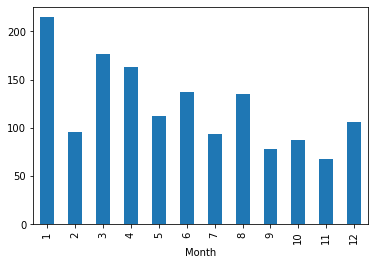

In [323]:
x=sales.drop_duplicates(subset=['CustomerID'], keep='first').groupby(by='Month').count()['CustomerID']
x.plot(kind='bar')
plt.show()

• Understand the retention of customers on month on month basis.

In [324]:
# Finding starting month for each customer.
a=sales.groupby(by='CustomerID')['Transaction_Date'].min().to_frame()
a=a.rename(columns={'Transaction_Date':'Start_month'})
a['Start_month']=a['Start_month'].dt.month

# Merging starting month column with sales data.
sales= sales.merge(a, on='CustomerID', how='inner')
sales['cohort_index']= sales['Month']-sales['Start_month']

<AxesSubplot:xlabel='cohort_index', ylabel='Start_month'>

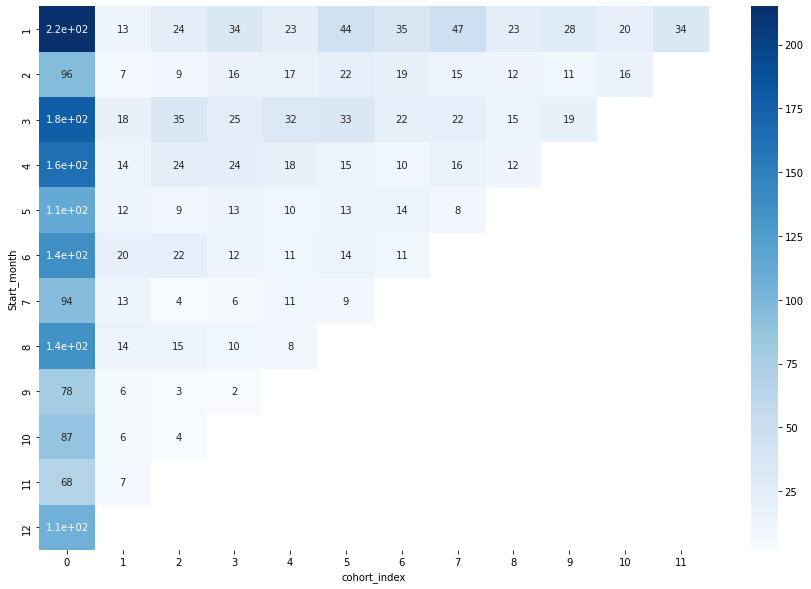

In [325]:
# Performing cohort analysis to calculate how many customers are retained for each month.
cohort_data=sales.groupby(['Start_month', 'cohort_index'])['CustomerID'].agg(pd.Series.nunique).reset_index()
cc = cohort_data.pivot_table(index = 'Start_month',columns = 'cohort_index',values = 'CustomerID')
plt.figure(figsize=(15,10))
sns.heatmap(cc, cmap='Blues', annot=True)

• How the revenues from existing/new customers on month on month basis

In [326]:
# Because the data is at product level, wo need to find transaction level revenue
c=sales.groupby(by='Transaction_ID').agg({'Invoice_amount':'sum'}).reset_index()
c.rename(columns={'Invoice_amount':'Amount_for_full_transaction'}, inplace=True)
sales=sales.merge(c, on='Transaction_ID', how='left')

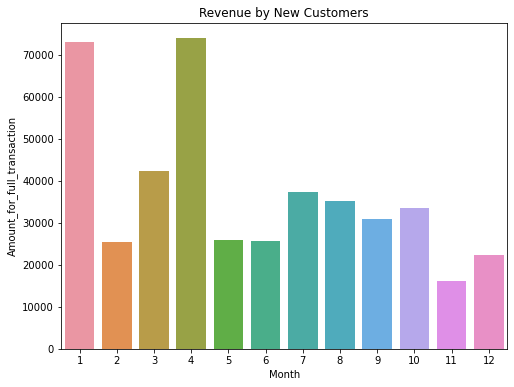

In [327]:
# Finding and plotting the monthly revenue by new customers
new_cust_sales=sales.drop_duplicates(subset='CustomerID', keep='first').groupby(by='Month')['Amount_for_full_transaction'].sum().to_frame().reset_index()
plt.figure(figsize=(8,6))
sns.barplot(x=new_cust_sales['Month'], y=new_cust_sales['Amount_for_full_transaction'])
plt.title('Revenue by New Customers')
plt.show()

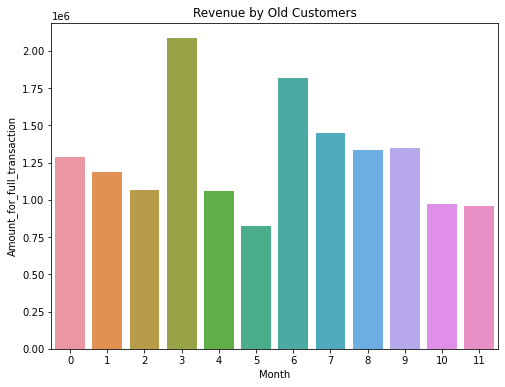

In [328]:
# Finding the sales by old customers by first finding total sales and subtracting new customer salesb
total_sales=sales.groupby(by='Month')['Amount_for_full_transaction'].sum().to_frame().reset_index()
old_cust_sales= total_sales-new_cust_sales
old_cust_sales= old_cust_sales.reset_index().drop(columns='Month')
plt.figure(figsize=(8,6))
sns.barplot(x=old_cust_sales['index'], y=old_cust_sales['Amount_for_full_transaction'])
plt.title('Revenue by Old Customers')
plt.xlabel('Month')
plt.show()

• How the discounts playing role in the revenues?

<AxesSubplot:xlabel='Discount_pct', ylabel='Invoice_amount'>

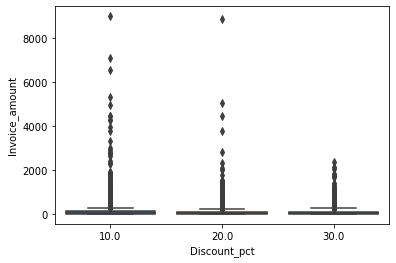

In [329]:
sns.boxplot(x=sales['Discount_pct'], y=sales['Invoice_amount'])
# We can see that higer the discount is, lower the maximum revenue is

 Analyse KPI’s like Revenue, number of orders, average order value, number of 
 customers (existing/new), quantity, by category, by month, by week, by day etc…

<AxesSubplot:xlabel='day', ylabel='Invoice_amount'>

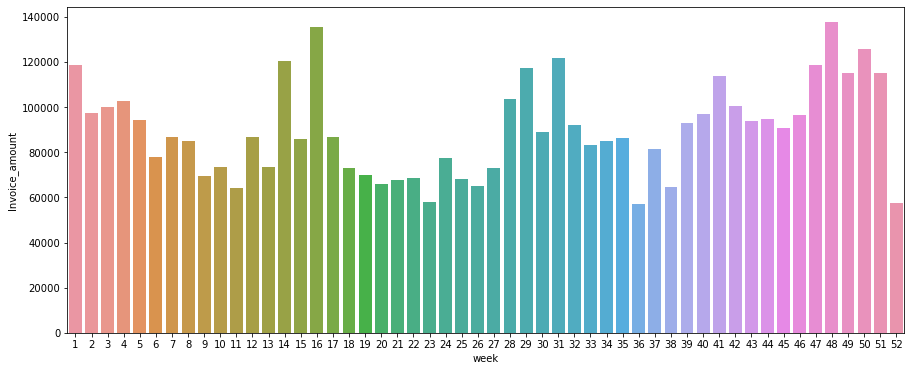

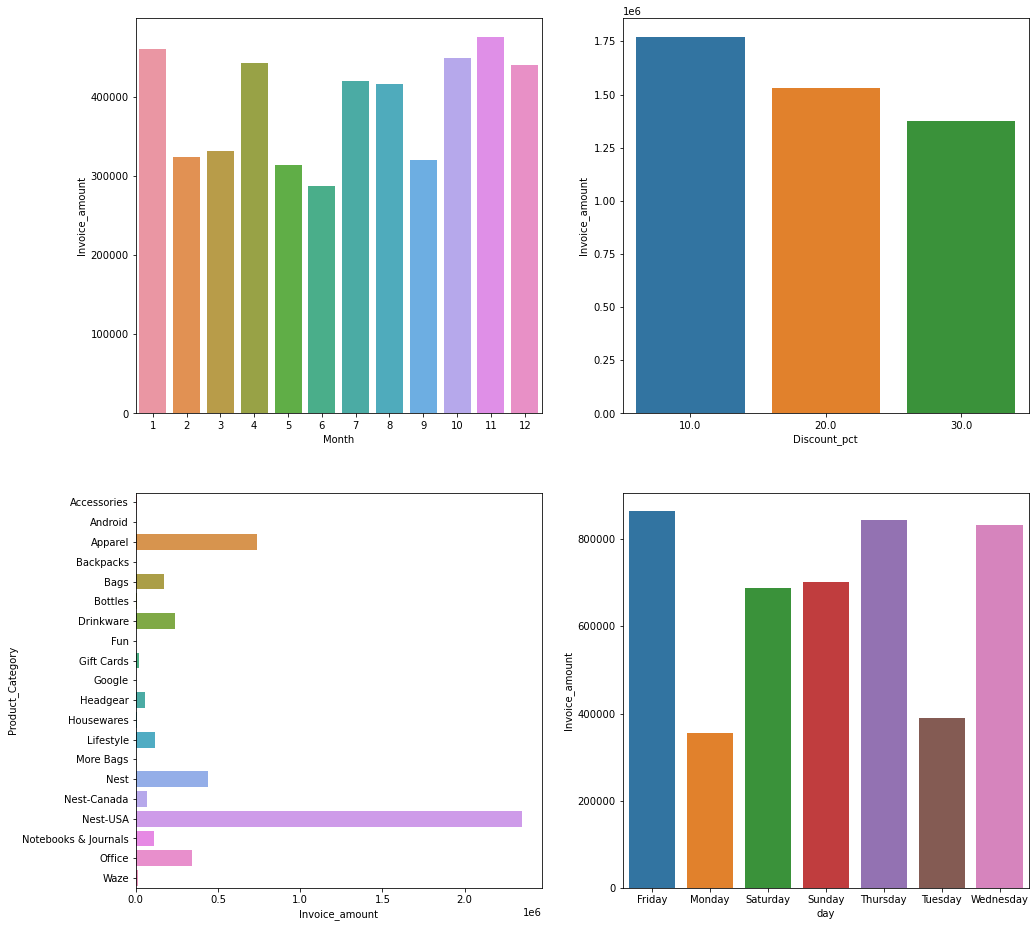

In [330]:
# Revenue

plt.figure(figsize=(15,6))
sns.barplot(data=sales.groupby('week')['Invoice_amount'].sum().to_frame().reset_index(), x='week', y='Invoice_amount')
fig, axes= plt.subplots(ncols=2,nrows=2, figsize=(16,16))
sns.barplot(data=sales.groupby('Month')['Invoice_amount'].sum().to_frame().reset_index(), x='Month', y='Invoice_amount', ax=axes[0,0])
sns.barplot(data=sales.groupby('Discount_pct')['Invoice_amount'].sum().to_frame().reset_index(), x='Discount_pct', y='Invoice_amount', ax=axes[0][1])
sns.barplot(data=sales.groupby('Product_Category')['Invoice_amount'].sum().to_frame().reset_index(), y='Product_Category', x='Invoice_amount', ax=axes[1,0])
sns.barplot(data=sales.groupby('day')['Invoice_amount'].sum().to_frame().reset_index(), x='day', y='Invoice_amount', ax=axes[1,1])

<AxesSubplot:xlabel='Discount_pct', ylabel='count'>

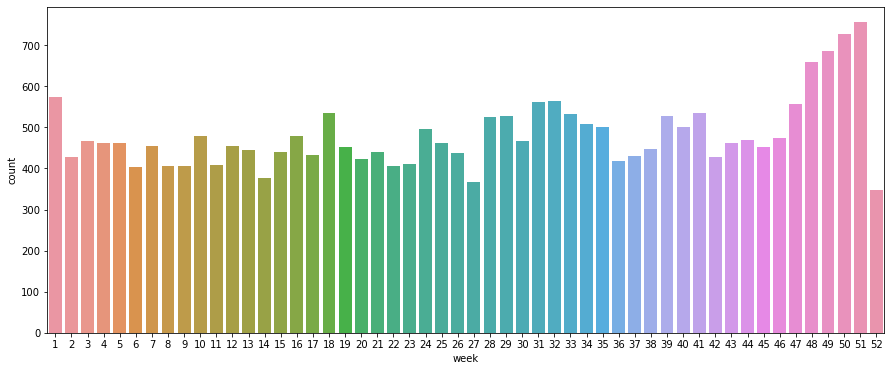

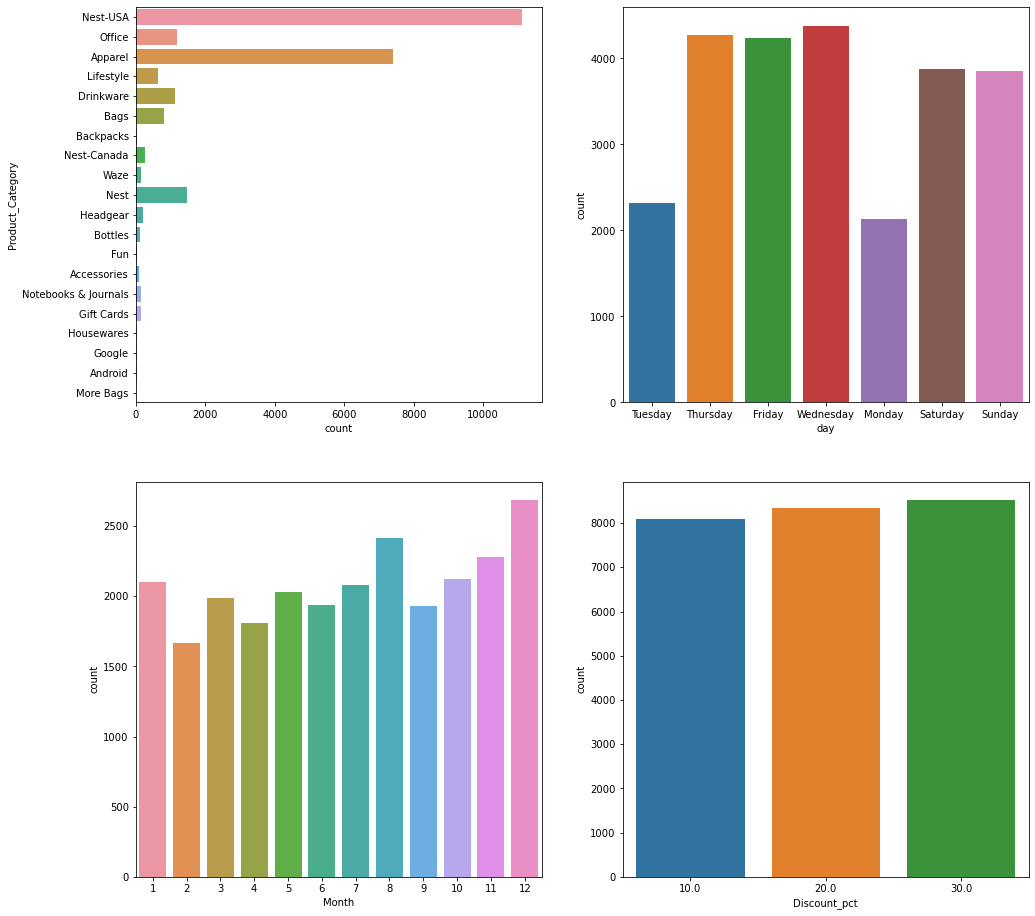

In [331]:
#No. of orders
# Dropping dulicated in in transactionID because data is at product level, not order level
plt.figure(figsize=(15,6))
sns.countplot(x=sales.drop_duplicates(subset=['Transaction_ID']).week)
fig, axes= plt.subplots(ncols=2,nrows=2, figsize=(16,16))
sns.countplot(x=sales.drop_duplicates(subset=['Transaction_ID']).day, ax= axes[0,1])
sns.countplot(y=sales.drop_duplicates(subset=['Transaction_ID']).Product_Category, ax= axes[0,0])
sns.countplot(x=sales.drop_duplicates(subset=['Transaction_ID']).Month, ax= axes[1,0])
sns.countplot(x=sales.drop_duplicates(subset=['Transaction_ID']).Discount_pct, ax= axes[1,1])

<AxesSubplot:xlabel='day', ylabel='Amount_for_full_transaction'>

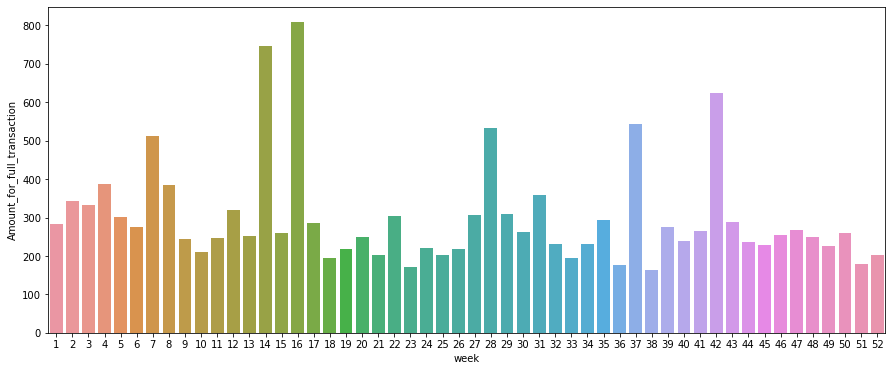

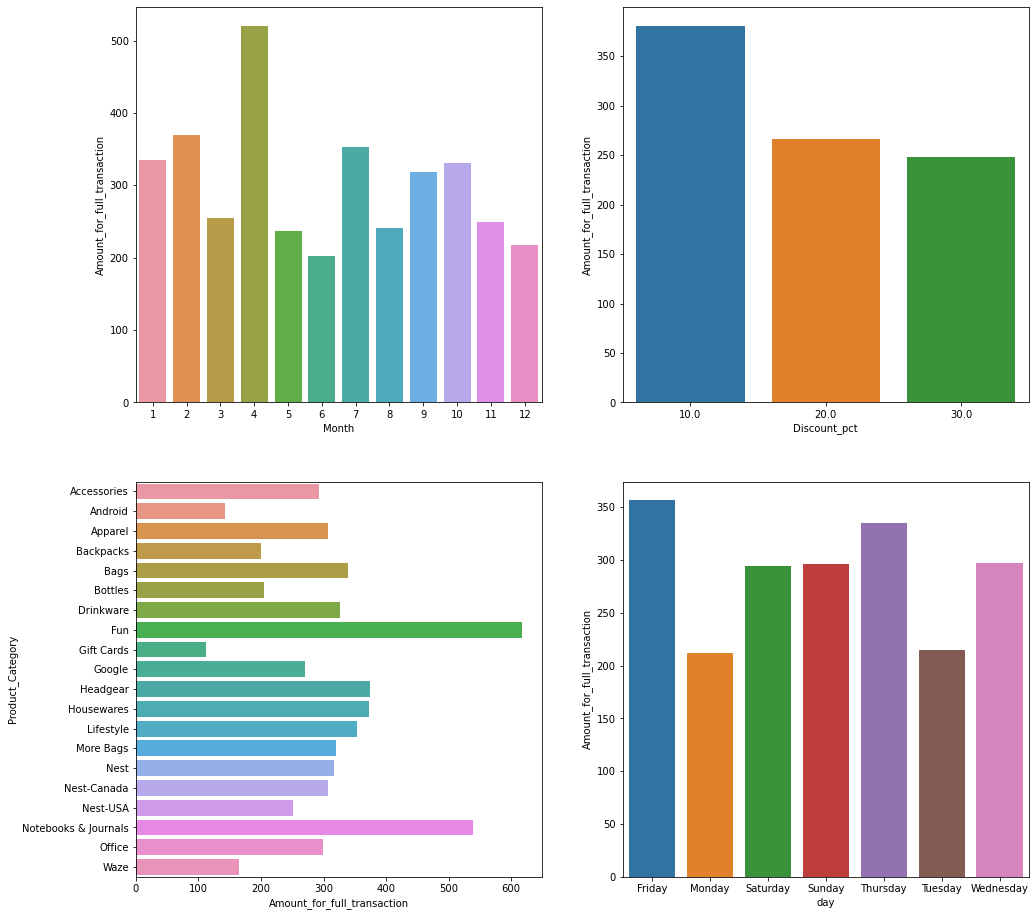

In [332]:
#Average order value

plt.figure(figsize=(15,6))
sns.barplot(data=sales.groupby('week')['Amount_for_full_transaction'].mean().to_frame().reset_index(), x='week', y='Amount_for_full_transaction')
fig, axes= plt.subplots(ncols=2,nrows=2, figsize=(16,16))
sns.barplot(data=sales.groupby('Month')['Amount_for_full_transaction'].mean().to_frame().reset_index(), x='Month', y='Amount_for_full_transaction', ax=axes[0,0])
sns.barplot(data=sales.groupby('Discount_pct')['Amount_for_full_transaction'].mean().to_frame().reset_index(), x='Discount_pct', y='Amount_for_full_transaction', ax=axes[0][1])
sns.barplot(data=sales.groupby('Product_Category')['Amount_for_full_transaction'].mean().to_frame().reset_index(), y='Product_Category', x='Amount_for_full_transaction', ax=axes[1,0])
sns.barplot(data=sales.groupby('day')['Amount_for_full_transaction'].mean().to_frame().reset_index(), x='day', y='Amount_for_full_transaction', ax=axes[1,1])


<AxesSubplot:xlabel='Discount_pct', ylabel='count'>

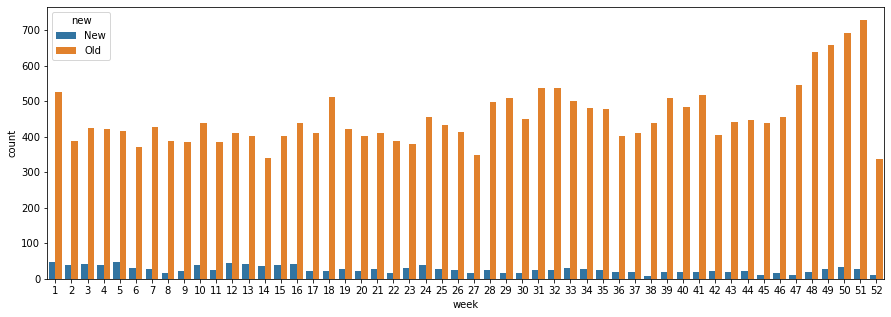

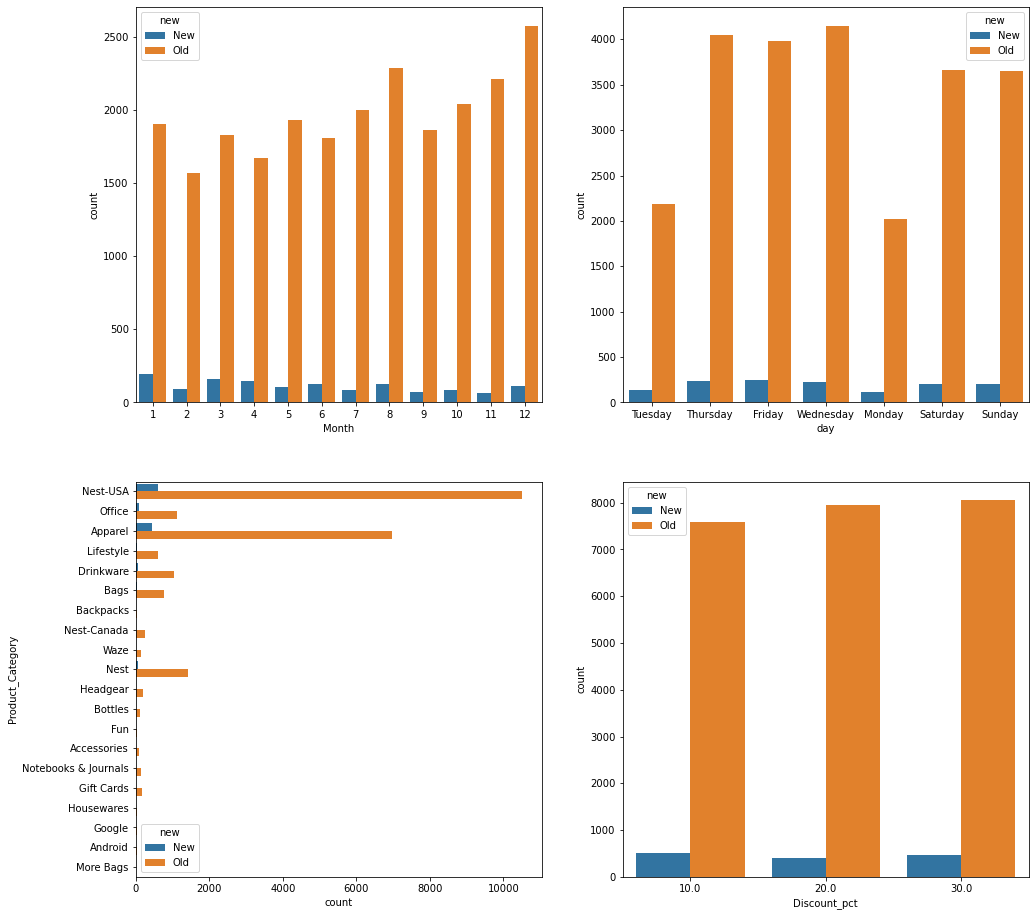

In [333]:
# No. of customers( new and old)
new_cust=sales.drop_duplicates(subset=['Transaction_ID']).drop_duplicates(subset='CustomerID', keep='first').index
sales['new']= np.where(sales.index.isin(new_cust), 'New', 'Old')

plt.figure(figsize=(15,5))
sns.countplot(x=sales.drop_duplicates(subset=['Transaction_ID']).week, hue=sales.new)
fig, axes= plt.subplots(ncols=2,nrows=2, figsize=(16,16))
sns.countplot(x=sales.drop_duplicates(subset=['Transaction_ID']).Month, hue=sales.new,ax=axes[0,0])
sns.countplot(x=sales.drop_duplicates(subset=['Transaction_ID']).day, hue=sales.new,ax=axes[0,1])
sns.countplot(y=sales.drop_duplicates(subset=['Transaction_ID']).Product_Category, hue=sales.new ,ax=axes[1,0])
sns.countplot(x=sales.drop_duplicates(subset=['Transaction_ID']).Discount_pct, hue=sales.new ,ax=axes[1,1])    

<AxesSubplot:xlabel='day', ylabel='Quantity'>

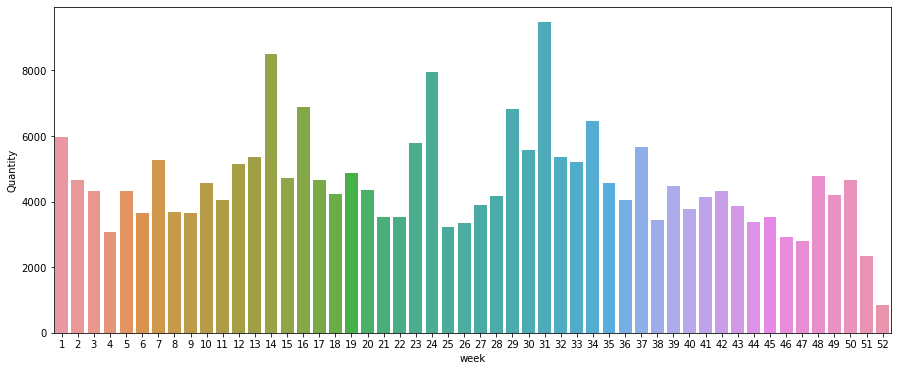

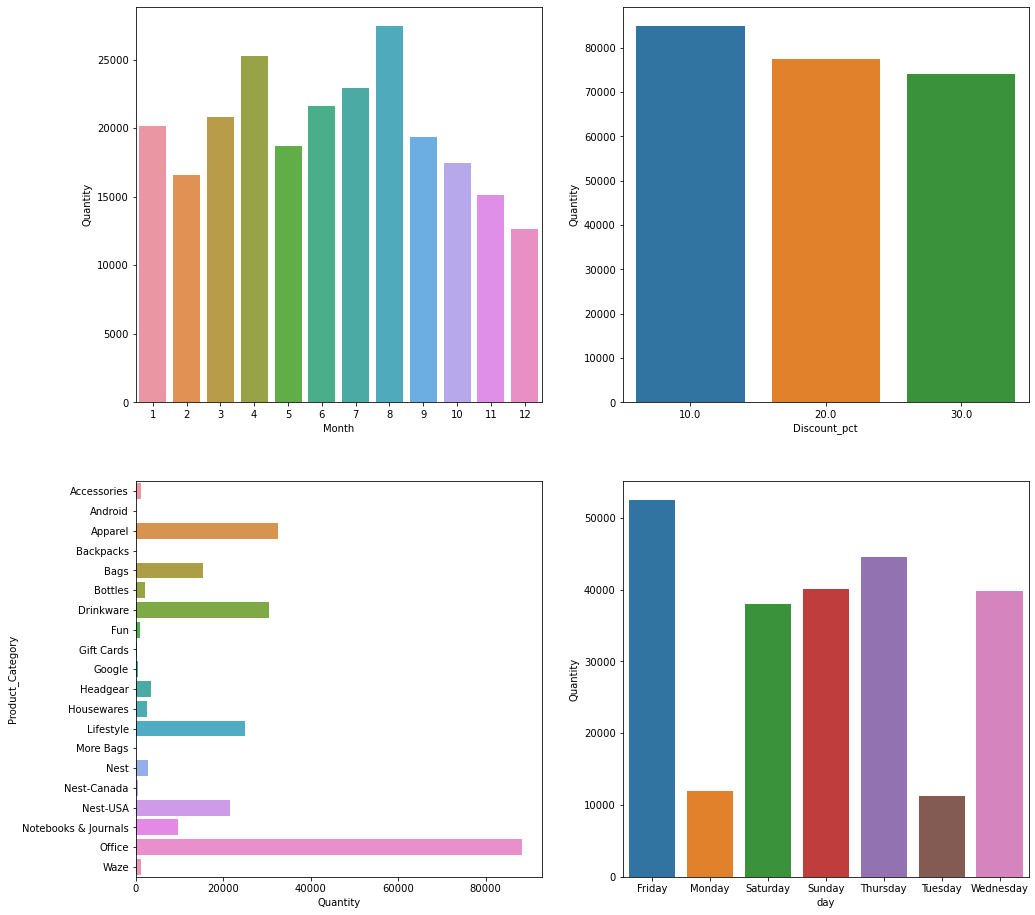

In [334]:
# Quantity

plt.figure(figsize=(15,6))
sns.barplot(data=sales.groupby('week')['Quantity'].sum().to_frame().reset_index(), x='week', y='Quantity')
fig, axes= plt.subplots(ncols=2,nrows=2, figsize=(16,16))
sns.barplot(data=sales.groupby('Month')['Quantity'].sum().to_frame().reset_index(), x='Month', y='Quantity', ax=axes[0,0])
sns.barplot(data=sales.groupby('Discount_pct')['Quantity'].sum().to_frame().reset_index(), x='Discount_pct', y='Quantity', ax=axes[0][1])
sns.barplot(data=sales.groupby('Product_Category')['Quantity'].sum().to_frame().reset_index(), y='Product_Category', x='Quantity', ax=axes[1,0])
sns.barplot(data=sales.groupby('day')['Quantity'].sum().to_frame().reset_index(), x='day', y='Quantity', ax=axes[1,1])

• Understand the trends/seasonality of sales by category, location, month etc…

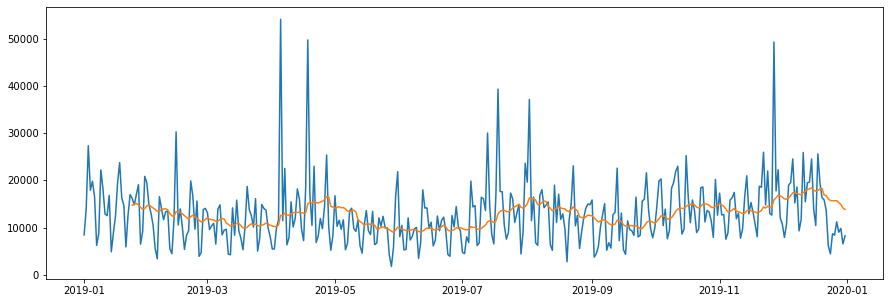

In [335]:

plt.figure(figsize=(15,5))
a= sales[['Transaction_Date','Invoice_amount']].groupby(by='Transaction_Date').sum()
plt.plot(a)
plt.plot(a.rolling(24).mean())

• Understand the trends/seasonality of sales by category, location, month etc…

<AxesSubplot:xlabel='Month', ylabel='Invoice_amount'>

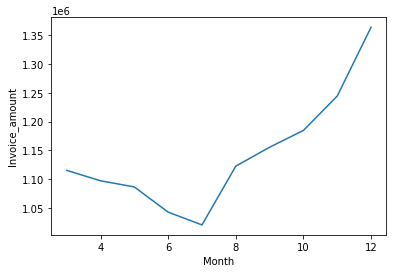

In [336]:
# By month
a= sales[['Month','Invoice_amount']].groupby(by='Month').sum()
a=a.rolling(3).sum()
sns.lineplot(data=a,  x='Month', y='Invoice_amount')

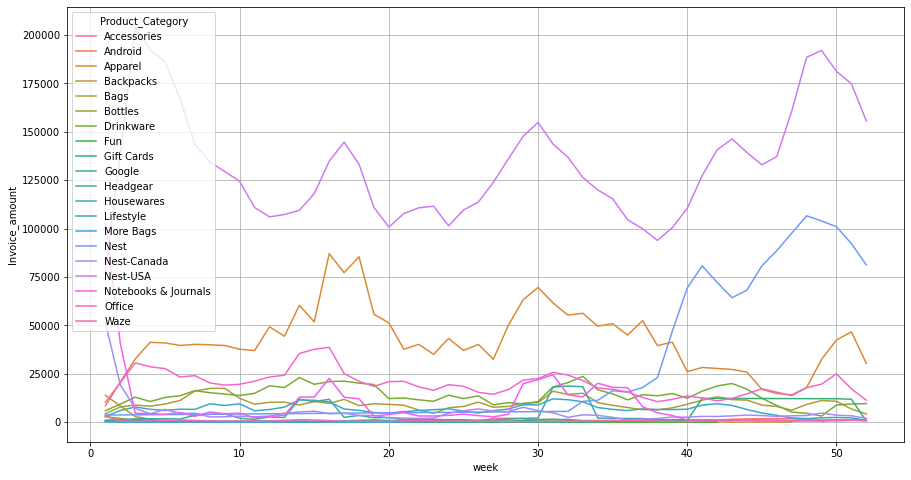

In [337]:
# Weekly trend by categories
plt.figure(figsize=(15,8))
a=sales.groupby(by=['Product_Category','week'])['Invoice_amount'].sum().reset_index()
a['Invoice_amount']= a['Invoice_amount'].rolling(3).sum()
sns.lineplot(data=a, x='week', y='Invoice_amount', hue='Product_Category')
plt.grid()
plt.show()

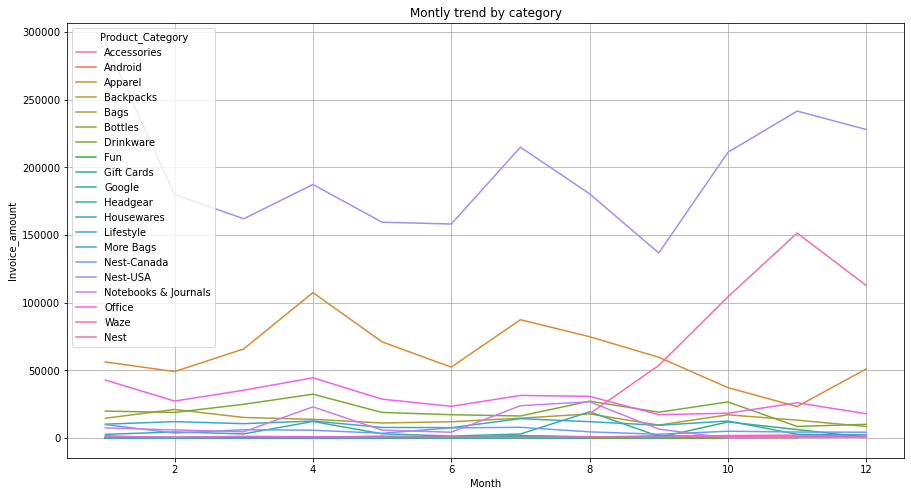

In [338]:
# Mpnthly trend by categories
plt.figure(figsize=(15,8))
a=sales.groupby(by=['Month','Product_Category'])['Invoice_amount'].sum().reset_index()
sns.lineplot(data=a, x='Month', y='Invoice_amount', hue='Product_Category')
plt.title('Montly trend by category')
plt.grid()
plt.show()

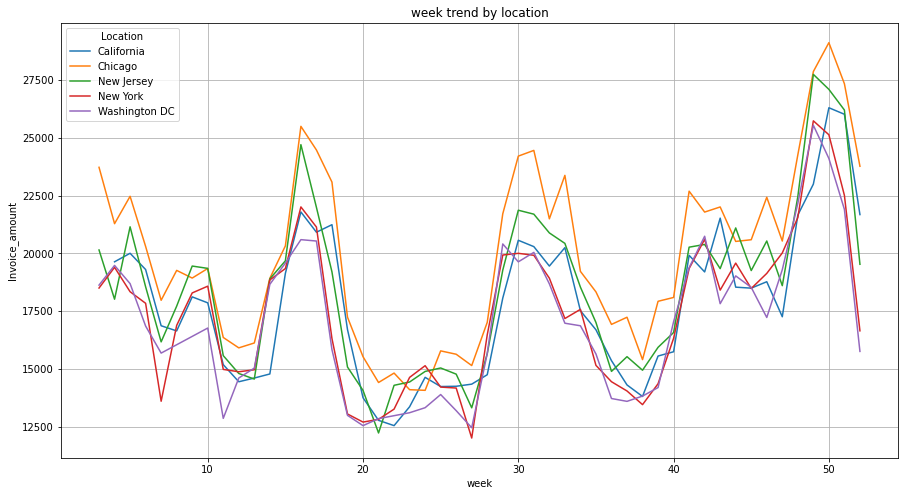

In [339]:
# Weekly trend by location
plt.figure(figsize=(15,8))
a=sales.groupby(by=['week','Location'])['Invoice_amount'].sum().reset_index()
a['Invoice_amount']= a['Invoice_amount'].rolling(12).mean()
sns.lineplot(data=a, x='week', y='Invoice_amount', hue='Location')
plt.title('week trend by location')
plt.grid()
plt.show()

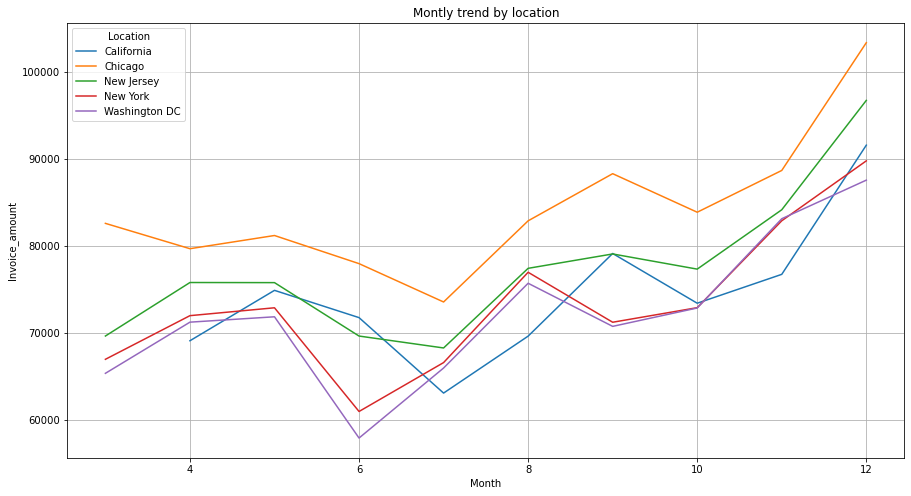

In [340]:
# Montly trend by location
plt.figure(figsize=(15,8))
a=sales.groupby(by=['Month','Location'])['Invoice_amount'].sum().reset_index()
a['Invoice_amount']= a['Invoice_amount'].rolling(12).mean()
sns.lineplot(data=a, x='Month', y='Invoice_amount', hue='Location')
plt.title('Montly trend by location')
plt.grid()
plt.show()

• How number order varies and sales with different days?

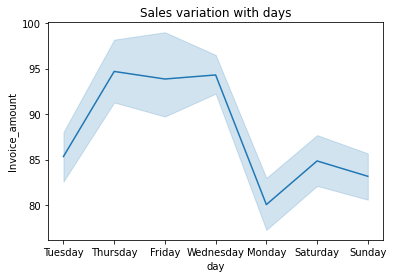

In [341]:
sns.lineplot(x = 'day', y = 'Invoice_amount', data = sales)
plt.title('Sales variation with days')
plt.show()

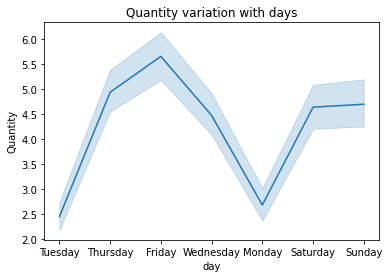

In [342]:
sns.lineplot(x = 'day', y = 'Quantity', data = sales)
plt.title('Quantity variation with days')
plt.show()

• Calculate the Revenue, Marketing spend, percentage of marketing spend out of
 revenue, Tax, percentage of delivery charges by month.

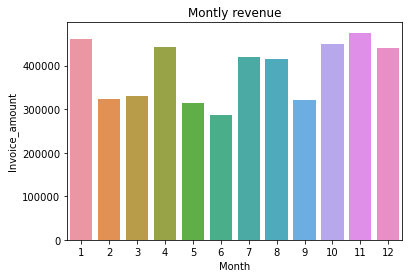

In [343]:
sns.barplot(data=sales.groupby(by='Month').sum().reset_index(), x='Month', y='Invoice_amount')
plt.title('Montly revenue')
plt.show()

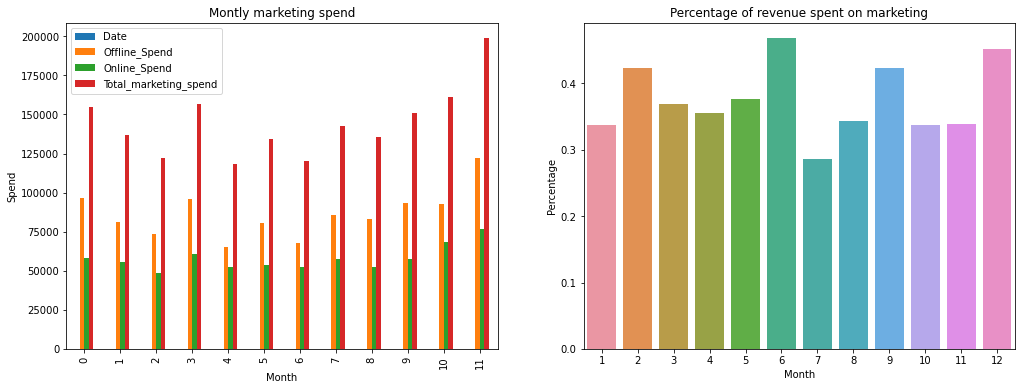

In [344]:
# Plotting monthly marketing spend and percetage of revenue spent of marketing
fig, axes= plt.subplots(ncols=2, figsize=(17,6))
ma=marketing.groupby(by=marketing.Date.dt.month).sum().reset_index()
ma.plot(kind='bar', ax= axes[0])
axes[0].set_title('Montly marketing spend')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Spend')

b=(marketing.groupby(by=marketing.Date.dt.month)['Total_marketing_spend'].sum()/sales.groupby(by='Month')['Invoice_amount'].sum()).to_frame()
sns.barplot(data=b, x=b.index, y=0, ax= axes[1])
axes[1].set_title('Percentage of revenue spent on marketing')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Percentage')
plt.show()



In [345]:
# Calculating tax amount
sales['tax']= sales['Invoice_amount']*sales['GST']

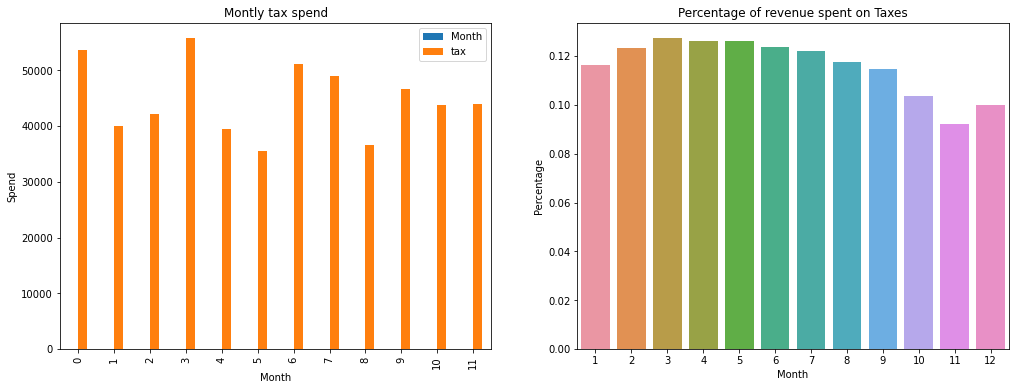

In [346]:
# Plotting montky Tax spend and percetage of money from gone to tax
fig, axes= plt.subplots(ncols=2, figsize=(17,6))
ma=sales.groupby(by='Month')['tax'].sum().reset_index()
ma.plot(kind='bar', ax= axes[0])
axes[0].set_title('Montly tax spend')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Spend')

b=(sales.groupby(by='Month')['tax'].sum()/sales.groupby(by='Month')['Invoice_amount'].sum()).to_frame()
sns.barplot(data=b, x=b.index, y=0, ax= axes[1])
axes[1].set_title('Percentage of revenue spent on Taxes')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Percentage')
plt.show()



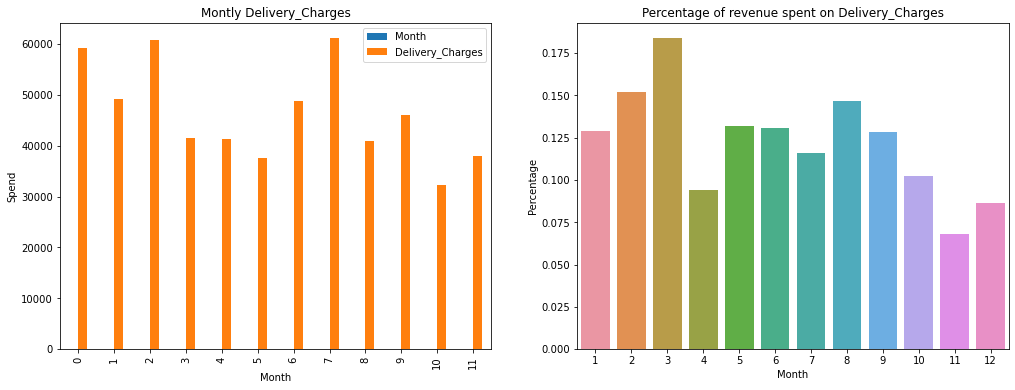

In [347]:
# # Plotting monthly spend on discount and percetage of revenue spent of discounts
fig, axes= plt.subplots(ncols=2, figsize=(17,6))
ma=sales.groupby(by='Month')['Delivery_Charges'].sum().reset_index()
ma.plot(kind='bar', ax= axes[0])
axes[0].set_title('Montly Delivery_Charges')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Spend')

b=(sales.groupby(by='Month')['Delivery_Charges'].sum()/sales.groupby(by='Month')['Invoice_amount'].sum()).to_frame()
sns.barplot(data=b, x=b.index, y=0, ax= axes[1])
axes[1].set_title('Percentage of revenue spent on Delivery_Charges')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Percentage')
plt.show()



•  How marketing spend is impacting on revenue?

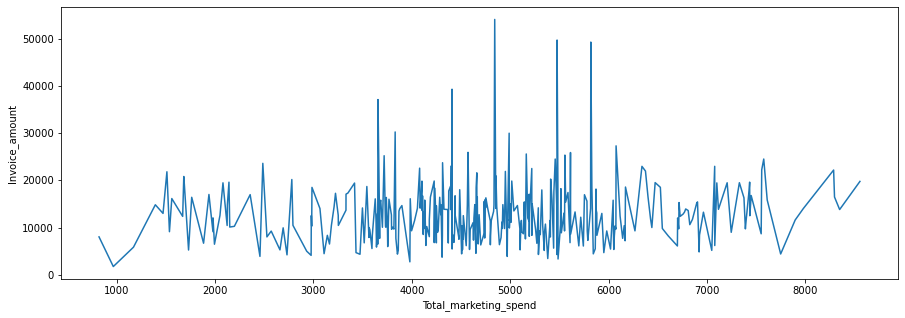

Correlation between marketing spend and revenue: 0.038336821680530694
Revenue goes up when marketing spend is between 3500 and 6000


In [348]:
marketing_revenue=sales.groupby(by='Date').agg({'Total_marketing_spend':'mean', 'Invoice_amount':'sum'})
plt.figure(figsize=(15,5))
sns.lineplot(data=marketing_revenue, y='Invoice_amount',x='Total_marketing_spend')
plt.show()
print('Correlation between marketing spend and revenue:', sales[['Total_marketing_spend','Invoice_amount']].corr().loc['Total_marketing_spend','Invoice_amount'])
print('Revenue goes up when marketing spend is between 3500 and 6000')

 • Which product was purchased mostly based on the quantity

In [349]:
# Top product by each month
top_prod_per_month=sales.groupby(by=['Month','Product_SKU'])['Transaction_ID'].count().to_frame().reset_index()
top_prod_per_month=top_prod_per_month.sort_values(by=['Month','Transaction_ID'], ascending=False)
top_prod_per_month.drop_duplicates(subset='Month', keep='first')

,Month,Product_SKU,Transaction_ID
5907,12,GGOENEBJ079499,384
5694,11,GGOENEBJ079499,335
5490,10,GGOENEBQ078999,271
5154,9,GGOENEBB078899,212
4748,8,GGOENEBQ078999,276
4217,7,GGOENEBQ078999,289
3586,6,GGOENEBQ078999,294
2966,5,GGOENEBB078899,251
2333,4,GGOENEBB078899,244
1639,3,GGOENEBQ078999,316


# 3. Performing Customer Segmentation

In [350]:
# Creating customer360 dataframe
c1=sales.groupby(by='CustomerID').agg({'Transaction_ID':'nunique',
                                   'Quantity':'sum',
                                   'Delivery_Charges':'sum',
                                   'Invoice_amount':'sum',
                                   'Transaction_Date': (lambda x: (max(x)-min(x)))   })
customer360= customer.merge(c1, on='CustomerID',how='inner')
customer360.rename(columns={'Transaction_ID':'Total_orders','Transaction_Date':'Tenure_days'}, inplace=True)
customer360.Tenure_days=customer360.Tenure_days.dt.days

 • Heuristic (Value based, RFM) – Divide the customers into Premium, Gold, Silver,
#Standard customers and define strategy on the same. 

In [351]:
# Creating a copy of customer data so we do not change the original table
sales_value_based= customer360.copy()

In [352]:
# Using qcut fucntion to divide the data in 10 segments based on invoice amount
sales_value_based['Segment']=pd.qcut(sales['Invoice_amount'],q=3, labels=False)
sales_value_based=sales_value_based.rename(columns={'Invoice_amount':'Total_revenue', 'Transaction_ID':'No. of transactions'})
sales_value_based

,CustomerID,Gender,Location,Tenure_Months,Total_orders,Quantity,Delivery_Charges,Total_revenue,Tenure_days,Segment
0,17850,M,Chicago,12,177,1133,3162.62,37649.28181,25,2.0
1,13047,M,California,43,26,175,315.96,2876.28679,351,2.0
2,12583,M,Chicago,33,15,155,757.27,2987.77264,213,0.0
3,13748,F,California,30,1,1,6.50,7.81688,0,2.0
4,15100,M,California,49,6,15,64.38,904.97624,241,1.0
...,...,...,...,...,...,...,...,...,...,...
1463,14438,F,New York,41,5,29,55.50,447.41712,1,0.0
1464,12956,F,Chicago,48,14,35,135.99,2426.63885,0,1.0
1465,15781,M,New Jersey,19,3,10,32.50,599.78042,0,1.0
1466,14410,F,New York,45,6,11,52.00,891.00257,0,2.0


In [353]:
# Finding centroids for numerical columns by each segment
sales_value_based.groupby(by='Segment').mean().sort_values(by='Total_revenue', ascending=False).drop(columns=['CustomerID','Tenure_Months'])

,Total_orders,Quantity,Delivery_Charges,Total_revenue,Tenure_days
Segment,,,,,
2.0,18.707865,174.222846,397.047172,3370.611168,67.754682
1.0,17.517621,150.770925,398.447489,3136.840686,60.398678
0.0,18.385776,160.146552,345.734547,3068.342923,65.976293


RFM 

In [354]:
# Creating a copy of customer data so we do not change the original table
RFM_data= sales.copy()

In [355]:
# Creating customer level table of data with No. of transactions, Total Invoice amount, 
# latest transaction date and No. of products purchased.
RFM=RFM_data.groupby(by='CustomerID').agg({'Transaction_ID':'nunique','Invoice_amount':'sum', 'Transaction_Date':'max','Product_SKU':'nunique',})

In [356]:
# Calculating the recency column
RFM['Recency']= (max(RFM['Transaction_Date'])-RFM['Transaction_Date'])/ np.timedelta64(1, 'D')

In [357]:
# Renaming columns for RFM
RFM.drop(columns='Transaction_Date', inplace=True)
RFM.rename(columns={
    'Transaction_ID':'Frequency',
    'Invoice_amount':'Monetary',
    'Product_SKU':'No._of_unique_products'
}, inplace=True)

In [358]:
# Finding three quantiles for frequency, monetary and recency
quantiles=RFM[['Frequency','Monetary','Recency']].quantile(q=[0.33,0.67])
quantiles


,Frequency,Monetary,Recency
0.33,7.0,940.351363,78.00
0.67,18.0,3035.112030,187.89


In [359]:
# Dividing the data in segments using the quantiles we found
RFM['r_seg']=np.where(RFM.Recency<=78,'Active', np.where(RFM.Recency<=187.89,'At-Risk', 'Churn'))
RFM['m_seg']=np.where(RFM.Monetary<=940.351363,1, np.where(RFM.Monetary<=3035.112030,2,3))
RFM['f_seg']=np.where(RFM.Frequency<=7,1, np.where(RFM.Frequency<=18,2,3))

In [360]:
# Setting custmers as Active, At-Risk, Churn according to recency and 
#Gold, platinum, Silver and Standard according to monetary and frequency
RFM['fm_seg'] = np.where(((RFM.f_seg == 3) & (RFM.m_seg ==3)) , 'Platinum',
                np.where((((RFM.f_seg == 3) & (RFM.m_seg ==2)) | ((RFM.f_seg == 2) & (RFM.m_seg ==3))) , 'Gold',
                np.where((((RFM.f_seg == 1) & (RFM.m_seg ==3)) | ((RFM.f_seg == 3) & (RFM.m_seg ==1)) | ((RFM.f_seg == 2) & (RFM.m_seg ==2))), 'Silver', 'Standard' )))

In [361]:
# Number of customers in each categories
RFM.groupby(by=['r_seg','fm_seg'])['Frequency'].count().T

r_seg    fm_seg  
Active   Gold         43
         Platinum    200
         Silver      118
         Standard    125
At-Risk  Gold         36
         Platinum    130
         Silver      116
         Standard    215
Churn    Gold         29
         Platinum     93
         Silver      109
         Standard    254
Name: Frequency, dtype: int64

In [362]:
# Creating a cross table between R and FM
RFM.groupby(by=['r_seg','fm_seg']).mean().T

r_seg                        Active                                     \
fm_seg                         Gold     Platinum       Silver Standard   
Frequency                 17.813953    47.860000    12.135593    4.528   
Monetary                3434.610336  8907.037282  2001.542802  675.719   
No._of_unique_products    25.255814    55.405000    18.211864    8.104   
Recency                   34.069767    35.305000    35.279661   36.224   
m_seg                      2.604651     3.000000     2.008475    1.208   
f_seg                      2.395349     3.000000     1.991525    1.104   

r_seg                       At-Risk                                        \
fm_seg                         Gold     Platinum       Silver    Standard   
Frequency                 18.694444    41.692308    12.224138    4.097674   
Monetary                3417.387843  7255.146222  1822.625571  535.615299   
No._of_unique_products    35.277778    58.438462    22.715517    8.246512   
Recency                  131.111111   123.107692   131.758621  134.506977   
m_seg                      2.500000     3.000000     2.008621    1.130233   
f_seg                      2.500000     3.000000     1.991379    1.088372   

r_seg                         Churn                                        
fm_seg                         Gold     Platinum       Silver    Standard  
Frequency                 18.689655    33.516129    11.577982    3.866142  
Monetary                3077.936590  6288.520205  1914.929111  599.302962  
No._of_unique_products    28.068966    45.365591    18.853211    7.767717  
Recency                  263.310345   273.806452   257.844037  269.574803  
m_seg                      2.482759     3.000000     2.018349    1.216535  
f_seg                      2.517241     3.000000     1.981651    1.062992

In [363]:
# Strategies
# There are many platinum customers which are in at-risk category, so need to make some time of retention campaign for those
# Number of silver and standard customers is decent in active category, so we need to make a upselling campaign for them 

In [364]:
# Creating a single category for each type
RFM['rfm_sement']= RFM['r_seg']+'_'+RFM['fm_seg']

In [365]:
#Value counts for each category
RFM['rfm_sement'].value_counts()

Churn_Standard      254
At-Risk_Standard    215
Active_Platinum     200
At-Risk_Platinum    130
Active_Standard     125
Active_Silver       118
At-Risk_Silver      116
Churn_Silver        109
Churn_Platinum       93
Active_Gold          43
At-Risk_Gold         36
Churn_Gold           29
Name: rfm_sement, dtype: int64

K-means clustering

In [366]:
# Creating a copy of customer data so we do not change the original table
K_means_data= customer360.copy()

In [367]:
# Encoding categorical columns
K_means_data= pd.get_dummies(K_means_data, drop_first=True)

In [368]:
# outlier treatment
def outlier_capping(x):
    x = x.clip(lower=x.quantile(0.03), upper=x.quantile(0.97))
    return x

K_means_data=K_means_data.apply(lambda x: outlier_capping(x))

In [369]:
# Finding the best value for K for Kmeans model
scores=[]
for i in range(3,8):
    k_model= KMeans(n_clusters=i, random_state=2343)
    k_model.fit(K_means_data)
    print(f'For k= {i}: Silhouette_score: {silhouette_score(K_means_data, k_model.labels_)}')

For k= 3: Silhouette_score: 0.41142834852809756
For k= 4: Silhouette_score: 0.4257558133001666
For k= 5: Silhouette_score: 0.4271926561272453
For k= 6: Silhouette_score: 0.3922475719999882
For k= 7: Silhouette_score: 0.37310627224806947


In [370]:
# K=3 gives the best silhouette score
# Final K-means model
k_model= KMeans(n_clusters=5, random_state=2343)
k_model.fit(K_means_data)

KMeans(n_clusters=5, random_state=2343)

In [371]:
#Adding segment column in dataset
K_means_data['segment']= k_model.labels_
K_means_data['segment'].value_counts()

0    497
2    452
4    222
1    167
3    130
Name: segment, dtype: int64

In [372]:
# Validating the segments
K_means_data.groupby(by='segment')['Total_orders','Quantity','Delivery_Charges','Invoice_amount','Tenure_days'].mean()

,Total_orders,Quantity,Delivery_Charges,Invoice_amount,Tenure_days
segment,,,,,
0,8.350101,62.998451,157.191308,1230.377795,42.802736
1,31.790419,257.978743,655.455541,5548.319062,104.167126
2,6.550885,48.088982,122.680996,923.633359,31.172412
3,53.961538,544.484077,1125.736463,10456.557003,167.806385
4,22.842342,193.638153,444.119505,3926.317052,85.706847


In [373]:
# Strategies
# We need to create a retention campaign for customers in segment 0 and 2 because customers are leaving too soon
# We need a upsell campaign for customer in segment 4 to bring them closer to segment 1


# 4. Predicting Customer Lifetime Value (Low Value/Medium Value/High Value)

In [374]:
# Making a cross table between customer_id and month with sales as values
sales2=sales.pivot_table(index=['CustomerID'],columns=['Month'],values='Invoice_amount',aggfunc='sum',fill_value=0).reset_index()

In [375]:
sales2

Month,CustomerID,1,2,3,4,5,6,7,8,9,10,11,12
0,12346,0.0,0.0,0.0000,0.00000,0.0,0.00000,0.00000,0.0000,174.98174,0.00000,0.000,0.00000
1,12347,0.0,0.0,9541.0638,0.00000,0.0,0.00000,0.00000,0.0000,0.00000,0.00000,2518.114,0.00000
2,12348,0.0,0.0,0.0000,0.00000,0.0,719.30382,0.00000,0.0000,0.00000,782.62238,0.000,0.00000
3,12350,0.0,0.0,0.0000,0.00000,0.0,0.00000,0.00000,0.0000,0.00000,0.00000,0.000,1183.71394
4,12356,0.0,0.0,0.0000,0.00000,0.0,0.00000,0.00000,0.0000,1753.45086,0.00000,0.000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1463,18259,0.0,0.0,0.0000,789.15360,0.0,0.00000,0.00000,0.0000,0.00000,0.00000,0.000,0.00000
1464,18260,0.0,0.0,0.0000,0.00000,0.0,1038.89191,0.00000,1231.0548,0.00000,303.70962,0.000,0.00000
1465,18269,0.0,0.0,0.0000,137.52698,0.0,18.13394,0.00000,0.0000,0.00000,0.00000,0.000,0.00000
1466,18277,0.0,0.0,0.0000,0.00000,0.0,0.00000,0.00000,0.0000,0.00000,301.02000,0.000,0.00000


In [376]:
# Finding sum of monthly sales for each customer
sales2['CLV']=sales2.iloc[:,2:].sum(axis=1)

In [377]:
# Extracting the necessary columns from dataset
df3 = sales2[['CustomerID',1,2,3,4,5,6,7,8,9,10,11,12,'CLV']]
df3.head()

Month,CustomerID,1,2,3,4,5,6,7,8,9,10,11,12,CLV
0,12346,0.0,0.0,0.0000,0.0,0.0,0.00000,0.0,0.0,174.98174,0.00000,0.000,0.00000,174.98174
1,12347,0.0,0.0,9541.0638,0.0,0.0,0.00000,0.0,0.0,0.00000,0.00000,2518.114,0.00000,12059.17780
2,12348,0.0,0.0,0.0000,0.0,0.0,719.30382,0.0,0.0,0.00000,782.62238,0.000,0.00000,1501.92620
3,12350,0.0,0.0,0.0000,0.0,0.0,0.00000,0.0,0.0,0.00000,0.00000,0.000,1183.71394,1183.71394
4,12356,0.0,0.0,0.0000,0.0,0.0,0.00000,0.0,0.0,1753.45086,0.00000,0.000,0.00000,1753.45086


In [378]:
# Checking how much CLV is affected by each month sales
corr_matrix = df3.corr()
corr_matrix['CLV'].sort_values(ascending=False)

Month
CLV           1.000000
4             0.603008
7             0.486051
2             0.428471
12            0.420166
3             0.404111
8             0.339946
9             0.337638
10            0.322365
5             0.299476
11            0.271494
6             0.256780
1             0.044167
CustomerID   -0.022902
Name: CLV, dtype: float64

In [379]:
# Making categories from CLV
df3['clv_segment']=pd.qcut(df3['CLV'],q=3, labels=False)
df3.drop(columns='CLV', inplace=True)

 Modelling

In [380]:
# Splitting the data in train and test
Y= df3['clv_segment']
X= df3.drop(columns=['CustomerID','clv_segment'])
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=432)

In [381]:
# KNN

In [382]:
# # Finding the best parameters for KNN Model
# from sklearn.neighbors import KNeighborsClassifier
# param_grid = {'n_neighbors':[5,7,9,11], 'weights':['uniform','distance']}
# grid= GridSearchCV(KNeighborsClassifier(), param_grid=param_grid, verbose=True).fit(X_train,y_train)
# print(grid.best_params_)

In [383]:
# Building KNN Model
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')
knn.fit(X_train, y_train)

import sklearn.metrics as metrics
print('Train roc_auc: ',metrics.roc_auc_score(y_train, knn.predict_proba(X_train),multi_class="ovr"))
print('Test roc_auc: ',metrics.roc_auc_score(y_test, knn.predict_proba(X_test),multi_class="ovr"))
print('Train accuracy: ',metrics.accuracy_score(y_train, knn.predict(X_train)))
print('Test accuracy: ',metrics.accuracy_score(y_test, knn.predict(X_test)))

Train roc_auc:  0.9935793250868477
Test roc_auc:  0.9731835152086171
Train accuracy:  0.9191820837390458
Test accuracy:  0.9002267573696145


In [384]:
# Support vector machine

In [385]:
# # Finding the best parameters for SVR Model
# svm_param_grid = {'C': [0.1, 1, 10, 100, 1000], 
#               'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
#               'kernel': ['rbf']} 
  
# grid = GridSearchCV(SVC(), param_grid=svm_param_grid, refit = True, verbose = False).fit(X_train, y_train)
# grid.best_params_

In [386]:
# Building SVR Model
svc= SVC(C=100, gamma=0.0001, kernel='rbf', probability=True).fit(X_train, y_train)

print('Train roc_auc: ',metrics.roc_auc_score(y_train, svc.predict_proba(X_train),multi_class="ovr"))
print('Test roc_auc: ',metrics.roc_auc_score(y_test, svc.predict_proba(X_test),multi_class="ovr"))
print('Train accuracy: ',metrics.accuracy_score(y_train, svc.predict(X_train)))
print('Test accuracy: ',metrics.accuracy_score(y_test, svc.predict(X_test)))

Train roc_auc:  1.0
Test roc_auc:  0.9777518585888286
Train accuracy:  1.0
Test accuracy:  0.8390022675736961


In [387]:
# Random Forest

In [388]:
# # Finding the best parameters for Random Forest Model
# param_grid = {"n_estimators": [50,100,200],
#               "max_depth": [3, 5,7],
#               "min_samples_split": [10,15, 20],
#               "min_samples_leaf": [5, 10, 20],
#               "max_leaf_nodes": [30, 40,50]}
# grid= GridSearchCV(RandomForestClassifier(), param_grid=param_grid, verbose=True).fit(X_train,y_train)
# print(grid.best_params_)

In [389]:
# Building Random Forest Model
rf = RandomForestClassifier(max_depth= 7, max_leaf_nodes= 50, min_samples_leaf= 5, min_samples_split= 10, n_estimators= 100)
rf.fit(X_train, y_train)

print('Train roc_auc: ',metrics.roc_auc_score(y_train, rf.predict_proba(X_train),multi_class="ovr"))
print('Test roc_auc: ',metrics.roc_auc_score(y_test, rf.predict_proba(X_test),multi_class="ovr"))
print('Train accuracy: ',metrics.accuracy_score(y_train, rf.predict(X_train)))
print('Test accuracy: ',metrics.accuracy_score(y_test, rf.predict(X_test)))

Train roc_auc:  0.966776066513729
Test roc_auc:  0.9454202205094876
Train accuracy:  0.8597857838364168
Test accuracy:  0.8639455782312925


In [390]:
# # Gradient boost
from sklearn.ensemble import GradientBoostingClassifier
# G_boost_params = {
#     "learning_rate": [0.01, 0.05, 0.1, 0.2],
#     "min_samples_split": np.linspace(0.1, 0.5, 5),
#     "min_samples_leaf": np.linspace(0.1, 0.5, 5),
#     "max_depth":[3,5,8],
#     "subsample":[0.5, 0.618, 0.85, 0.9, 1.0],
#     "n_estimators":[10,50]
#     }
# grid= GridSearchCV(GradientBoostingClassifier(), param_grid=G_boost_params, verbose=True, n_jobs=4).fit(X_train, y_train)
# grid.best_params_

In [391]:
gb= GradientBoostingClassifier(learning_rate=0.2, max_depth=8, min_samples_leaf=0.1, min_samples_split=0.1,n_estimators=50,subsample=1.0).fit(X_train, y_train)

print('Train roc_auc: ',metrics.roc_auc_score(y_train, gb.predict_proba(X_train),multi_class="ovr"))
print('Test roc_auc: ',metrics.roc_auc_score(y_test, gb.predict_proba(X_test),multi_class="ovr"))
print('Train accuracy: ',metrics.accuracy_score(y_train, gb.predict(X_train)))
print('Test accuracy: ',metrics.accuracy_score(y_test, gb.predict(X_test)))

Train roc_auc:  0.8852687247250359
Test roc_auc:  0.867356442121651
Train accuracy:  0.7419668938656281
Test accuracy:  0.7006802721088435


In [392]:
# XGBOOST
xgb_model0=XGBClassifier(colsample_bytree=0.6,
                        gamma=0.5, 
                        max_depth=3, 
                        min_child_weight=5, 
                        subsample=0.6).fit(X_train, y_train)


print('Train roc_auc: ',metrics.roc_auc_score(y_train, xgb_model0.predict_proba(X_train),multi_class="ovr"))
print('Test roc_auc: ',metrics.roc_auc_score(y_test, xgb_model0.predict_proba(X_test),multi_class="ovr"))
print('Train accuracy: ',metrics.accuracy_score(y_train, xgb_model0.predict(X_train)))
print('Test accuracy: ',metrics.accuracy_score(y_test, xgb_model0.predict(X_test)))

Train roc_auc:  0.9976244055930401
Test roc_auc:  0.982274236370487
Train accuracy:  0.9668938656280428
Test accuracy:  0.9138321995464853


# 5. Cross-Selling (Which products are selling together)


By EDA

In [393]:
# Creating a copy of sales and taking only transaction numbers that are repeated
sales3= sales[sales['Transaction_ID'].duplicated(keep=False)]

In [394]:
# Joining all the products bought for each transaction
sales3['bundle']=sales3.groupby(by='Transaction_ID')['Product_SKU'].transform(lambda x: ','.join(x))
sales3=sales3[['Transaction_ID','bundle']].drop_duplicates()

In [395]:
# Using itertools and collections to find which cobinations are most common and how many times
from itertools import combinations
from collections import Counter
for j in [2,3,5]:
    count= Counter()
    for i in sales3['bundle']:
        prod_list= i.split(',')
        count.update(Counter(combinations(prod_list,j)))
    print(f'Top 10 groups with {j} elemnts')
    display(pd.DataFrame(count.most_common(10)))

Top 10 groups with 2 elemnts


,0,1
0,"(GGOENEBB078899, GGOENEBQ078999)",672
1,"(GGOENEBJ079499, GGOENEBQ078999)",294
2,"(GGOEGHGC019799, GGOEGHGR019499)",252
3,"(GGOEGHGH019699, GGOEGHGT019599)",230
4,"(GGOEGHGR019499, GGOEGHGT019599)",230
5,"(GGOEGHGC019799, GGOEGHGH019699)",224
6,"(GGOEGHGH019699, GGOEGHGR019499)",224
7,"(GGOENEBB078899, GGOENEBJ079499)",223
8,"(GGOENEBJ079499, GGOENEBQ079099)",221
9,"(GGOEGHGC019799, GGOEGHGT019599)",216


Top 10 groups with 3 elemnts


,0,1
0,"(GGOEGHGH019699, GGOEGHGR019499, GGOEGHGT019599)",187
1,"(GGOEGHGC019799, GGOEGHGH019699, GGOEGHGR019499)",185
2,"(GGOEGHGC019799, GGOEGHGR019499, GGOEGHGT019599)",184
3,"(GGOEGHGC019799, GGOEGHGH019699, GGOEGHGT019599)",170
4,"(GGOENEBB078899, GGOENEBJ079499, GGOENEBQ078999)",80
5,"(GGOENEBB078899, GGOENEBQ078999, GGOENEBQ079099)",60
6,"(GGOENEBJ079499, GGOENEBQ078999, GGOENEBQ079099)",43
7,"(GGOENEBB078899, GGOENEBJ079499, GGOENEBQ079099)",35
8,"(GGOEGBMJ013399, GGOEGDHC018299, GGOEGDHR018499)",34
9,"(GGOEGDHC018299, GGOEGDHR018499, GGOEGFKQ020399)",34


Top 10 groups with 5 elemnts


,0,1
0,"(GGOEGDHC018299, GGOEGDHR018499, GGOEGHGH01969...",21
1,"(GGOEGDHC018299, GGOEGHGC019799, GGOEGHGH01969...",21
2,"(GGOEGDHC018299, GGOEGDHR018499, GGOEGHGC01979...",19
3,"(GGOEGDHC018299, GGOEGDHR018499, GGOEGHGC01979...",19
4,"(GGOEGDHC018299, GGOEGDHR018499, GGOEGHGC01979...",18
5,"(GGOEGDHR018499, GGOEGHGC019799, GGOEGHGH01969...",17
6,"(GGOEGFSR022099, GGOEGHGC019799, GGOEGHGH01969...",17
7,"(GGOEAKDH019899, GGOEGHGC019799, GGOEGHGH01969...",16
8,"(GGOEGBMJ013399, GGOEGHGC019799, GGOEGHGH01969...",14
9,"(GGOEGFKQ020399, GGOEGHGC019799, GGOEGHGH01969...",14


By using distance

In [396]:
# Creating list of products and making a pivot table between product and transaction
list_products = list(set(sales.Product_SKU))
cust_prod=sales.pivot_table(index='Product_SKU', columns='Transaction_ID', values='CustomerID', aggfunc='count').fillna(0)

In [397]:
# Finding distance between each set of product and storing it in a dataframe
prod_prod_similarity= pairwise_distances(cust_prod, metric='euclidean')
prod_prod_similarity = pd.DataFrame(prod_prod_similarity, columns =list_products, index= list_products )
prod_prod_similarity.head()

,GGOEAAFB035917,GGOEGAYC068326,GGOEYAEJ029014,GGOEYOLR018699,GGOEGAXP089329,GGOEGAAR010715,GGOEAAXC066430,GGOEYAAQ031714,GGOEGAAL010616,GGOEGAWR061050,...,GGOEYAEJ092116,GGOEGAER035513,GGOEYAXR066130,GGOEAAAP081217,GGOEGADJ059716,GGOEGAAJ080615,GGOEYAEB091818,GGOEGAAJ032717,GGOEGAEB027816,GGOEGADC059513
GGOEAAFB035917,0.000000,5.830952,7.681146,6.855655,6.164414,5.196152,5.744563,8.124038,6.480741,6.000000,...,6.480741,5.567764,14.000000,5.830952,4.795832,6.324555,8.426150,7.000000,11.916375,6.928203
GGOEGAYC068326,5.830952,0.000000,7.141428,6.855655,6.000000,5.196152,5.196152,8.246211,6.633250,6.164414,...,6.633250,5.744563,14.142136,6.000000,5.000000,6.480741,8.888194,7.141428,12.000000,7.071068
GGOEYAEJ029014,7.681146,7.141428,0.000000,8.485281,7.810250,7.211103,7.745967,9.219544,8.306624,7.937254,...,8.306624,7.615773,15.000000,7.810250,7.071068,8.185353,10.198039,8.717798,13.000000,8.660254
GGOEYOLR018699,6.855655,6.855655,8.485281,0.000000,6.855655,6.480741,6.928203,8.888194,7.141428,7.141428,...,7.549834,6.782330,14.594520,7.000000,6.164414,7.280110,9.591663,7.874008,12.529964,7.937254
GGOEGAXP089329,6.164414,6.000000,7.810250,6.855655,0.000000,5.567764,6.244998,8.485281,6.928203,6.000000,...,6.928203,6.082763,14.282857,6.324555,5.385165,6.782330,9.110434,7.416198,12.083046,7.348469


In [398]:
# Top 10 similar products for each products
top_10_similar_products=pd.DataFrame(index=list_products,columns=['P1','P2','P3','P4','P5','P6','P7','P8','P9','P10'])
for i in prod_prod_similarity:
    l=list([prod_prod_similarity[i].sort_values()[1:11].index])
    for j,k in enumerate(['P1','P2','P3','P4','P5','P6','P7','P8','P9','P10']):
        top_10_similar_products.loc[i,k]=l.__getitem__(0).__getitem__(j)

In [399]:
top_10_similar_products.head()

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10
GGOEAAFB035917,GGOEGBFC018799,GGOEGAAJ073417,GGOEWEBB082699,GGOEGAAR010717,GGOEGALL060016,GGOEGAXL089430,GGOEGAPB058614,GGOEGADB059615,GGOEGAFB035814,GGOEGDHC087099
GGOEGAYC068326,GGOEGAET090516,GGOEGAAL059017,GGOEGPXC023299,GGOEGAAC035016,GGOEYAYR068625,GGOEGAXB089255,GGOEGAET090514,GGOEAAEB030213,GGOEGAAJ080715,GGOEGAEJ030817
GGOEYAEJ029014,GGOEGADB059217,GGOEAAAL081114,GGOEGALL074615,GGOEGADB056918,GGOEAAWC061654,GGOEYAEB091815,GGOEGAQB036013,GGOEGALB034114,GGOEGAWR061153,GGOEGADJ059715
GGOEYOLR018699,GGOEAAAL081114,GGOEGADC059314,GGOEYAYR068625,GGOEGAXB089255,GGOEGAET090514,GGOEWAAJ082817,GGOEGAYT068524,GGOEGAER035516,GGOEGBFC018799,GGOEGADC059515
GGOEGAXP089329,GGOEGALJ036415,GGOEGALL074615,GGOEGAAJ057014,GGOENEBJ079499,GGOEGAWR061048,GGOEGALQ036614,GGOEGAAL059017,GGOEGAEJ028014,GGOEGAXL065929,GGOEGAPB057813


In [400]:
# Example: Top 10 similar products for product_sku GGOEGAEJ028113
top_10_similar_products[top_10_similar_products.index=='GGOEGAEJ028113']

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10
GGOEGAEJ028113,GGOEYAYR068625,GGOEGALL074615,GGOEAAWC061654,GGOEGALQ036614,GGOEGAQB036013,GGOEYAEB091815,GGOENEBQ086799,GGOEGAAJ032315,GGOEGOBG023599,GGOEAAAL081114


 By using apriori algorithm

In [401]:
# Creating a table for what products are present in each transaction
basket = (sales.groupby(['Transaction_ID', 'Product_SKU'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('Transaction_ID'))

In [402]:
basket

Product_SKU,GGOEA0CH077599,GGOEAAAB034813,GGOEAAAB034814,GGOEAAAB034815,GGOEAAAB034816,GGOEAAAB034817,GGOEAAAB034913,GGOEAAAB034914,GGOEAAAB034915,GGOEAAAB034916,...,GGOEYHPA003510,GGOEYHPA003610,GGOEYHPB072210,GGOEYOBR078599,GGOEYOCB092699,GGOEYOCR077399,GGOEYOCR077799,GGOEYOCR078099,GGOEYOLR018699,GGOEYOLR080599
Transaction_ID,,,,,,,,,,,,,,,,,,,,,
16679,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16680,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16681,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16682,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16684,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48493,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48494,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48495,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [403]:
# Encoding the value by 1 and 0
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1 
basket_sets = basket.applymap(encode_units)

In [404]:
# Using apriori algorithm to find most frequent itemsets
freq_itemsets= apriori(basket_sets,min_support=0.005, use_colnames=True)

In [405]:
# Generating assosiation rules
rules = association_rules(freq_itemsets, metric="lift", min_threshold=1)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(GGOEGDHC018299),(GGOEGDHR018499),0.023263,0.012729,0.008699,0.373928,29.376202,0.008403,1.576929
1,(GGOEGDHR018499),(GGOEGDHC018299),0.012729,0.023263,0.008699,0.683386,29.376202,0.008403,3.084941
2,(GGOEGFKQ020399),(GGOEYFKQ020699),0.032162,0.016719,0.005347,0.166253,9.943840,0.004809,1.179352
3,(GGOEYFKQ020699),(GGOEGFKQ020399),0.016719,0.032162,0.005347,0.319809,9.943840,0.004809,1.422892
4,(GGOEGHGC019799),(GGOEGHGH019699),0.017677,0.015482,0.009297,0.525959,33.971824,0.009024,2.076864
...,...,...,...,...,...,...,...,...,...
57,"(GGOEGHGH019699, GGOEGHGT019599)","(GGOEGHGR019499, GGOEGHGC019799)",0.009656,0.010654,0.006903,0.714876,67.099282,0.006800,3.469880
58,(GGOEGHGR019499),"(GGOEGHGC019799, GGOEGHGH019699, GGOEGHGT019599)",0.014644,0.007502,0.006903,0.471390,62.837744,0.006793,1.877561
59,(GGOEGHGC019799),"(GGOEGHGR019499, GGOEGHGH019699, GGOEGHGT019599)",0.017677,0.007941,0.006903,0.390519,49.179906,0.006763,1.627712
60,(GGOEGHGH019699),"(GGOEGHGR019499, GGOEGHGC019799, GGOEGHGT019599)",0.015482,0.008060,0.006903,0.445876,55.317355,0.006778,1.790105


In [406]:
rules.sort_values(by='confidence', ascending=False )

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
51,"(GGOEGHGC019799, GGOEGHGH019699, GGOEGHGT019599)",(GGOEGHGR019499),0.007502,0.014644,0.006903,0.920213,62.837744,0.006793,12.349792
50,"(GGOEGHGR019499, GGOEGHGH019699, GGOEGHGT019599)",(GGOEGHGC019799),0.007941,0.017677,0.006903,0.869347,49.179906,0.006763,7.518550
26,"(GGOEGHGC019799, GGOEGHGH019699)",(GGOEGHGR019499),0.009297,0.014644,0.008020,0.862661,58.907755,0.007884,7.174621
25,"(GGOEGHGR019499, GGOEGHGH019699)",(GGOEGHGC019799),0.009297,0.017677,0.008020,0.862661,48.801684,0.007856,7.152540
48,"(GGOEGHGR019499, GGOEGHGC019799, GGOEGHGH019699)",(GGOEGHGT019599),0.008020,0.012968,0.006903,0.860697,66.368971,0.006799,7.085477
...,...,...,...,...,...,...,...,...,...
18,(GGOENEBQ079099),(GGOENEBJ079499),0.054307,0.140098,0.009018,0.166054,1.185272,0.001410,1.031125
22,(GGOENEBQ079099),(GGOENEBQ078999),0.054307,0.132796,0.007661,0.141073,1.062327,0.000449,1.009636
19,(GGOENEBJ079499),(GGOENEBQ079099),0.140098,0.054307,0.009018,0.064369,1.185272,0.001410,1.010754
23,(GGOENEBQ078999),(GGOENEBQ079099),0.132796,0.054307,0.007661,0.057692,1.062327,0.000449,1.003592


6. Predicting Next Purchase Day(How soon each customer can visit the store (0-30 days, 30-60
days, 60-90 days, 90+ days)
• For this, we need create dependent variable at customer level (average days per one
transaction for only repeat customers and divide into groups 0-30 days, 30-60 days,
60-90 days and 90+ days) then build classification model to predict next purchase of
given customer.

In [407]:
customer360['Average_trans_days']=customer360['Tenure_days']/customer360['Total_orders']

<AxesSubplot:xlabel='Average_trans_days', ylabel='Density'>

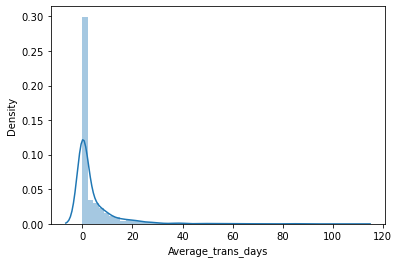

In [408]:
sns.distplot(customer360['Average_trans_days'])

In [409]:
# 30 days gap is not working because only 23 records are above 30 days, so we'll use 20 days

In [410]:
customer360['Next_purchase_segment']= np.where(customer360.Average_trans_days<=20,0,
                                               np.where(customer360.Average_trans_days<=40,1,
                                                       np.where(customer360.Average_trans_days<=60,2,3)))

In [411]:
# Splitting the data in train and test
Y= customer360['Next_purchase_segment']
X= customer360.drop(columns=['Next_purchase_segment','CustomerID'])
X=pd.get_dummies(X)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=432)

In [412]:
# Outlier treatment
def outlier(x):
    if (x.dtype=='int64')|(x.dtype=='float64'):
        x.clip(upper = x.quantile(0.99), lower = x.quantile(0.01) )
    return x

X_train = X_train.apply(outlier)
X_test = X_test.apply(outlier)

In [413]:
# Standardization of data
from sklearn.preprocessing import MinMaxScaler
scaler= MinMaxScaler().fit(X_train)
x_train_std=pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
x_test_std=pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [414]:
# Balancing the dataset
from imblearn.over_sampling import SMOTE
smt= SMOTE(k_neighbors=1)
x_train_final, y_train_final= smt.fit_resample(x_train_std, y_train)

Modelling

In [415]:
# Logistic Regression model
from sklearn.linear_model import LogisticRegression
ln_model= LogisticRegression().fit(x_train_std, y_train)
print(metrics.classification_report(y_train_final, ln_model.predict(x_train_final)))
print(metrics.classification_report(y_test, ln_model.predict(x_test_std)))

              precision    recall  f1-score   support

           0       0.49      1.00      0.66       971
           1       0.04      0.07      0.05       971
           2       0.00      0.00      0.00       971
           3       0.00      0.00      0.00       971

    accuracy                           0.27      3884
   macro avg       0.13      0.27      0.18      3884
weighted avg       0.13      0.27      0.18      3884

              precision    recall  f1-score   support

           0       0.95      1.00      0.98       415
           1       0.00      0.00      0.00        21
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         4

    accuracy                           0.94       441
   macro avg       0.24      0.25      0.24       441
weighted avg       0.90      0.94      0.92       441



In [416]:
# KNNClassifier model
from sklearn.neighbors import KNeighborsClassifier
ln_model= KNeighborsClassifier(n_neighbors=5, weights='uniform').fit(x_train_std, y_train)
print(metrics.classification_report(y_train, ln_model.predict(x_train_std)))
print(metrics.classification_report(y_test, ln_model.predict(x_test_std)))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       971
           1       0.79      0.46      0.58        41
           2       0.86      0.55      0.67        11
           3       0.00      0.00      0.00         4

    accuracy                           0.97      1027
   macro avg       0.66      0.50      0.56      1027
weighted avg       0.96      0.97      0.96      1027

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       415
           1       0.33      0.05      0.08        21
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         4

    accuracy                           0.94       441
   macro avg       0.32      0.26      0.26       441
weighted avg       0.91      0.94      0.92       441



In [417]:
# #Decision tree classifier

# Finding the best parameters for decision tree classifier
# dt_param={'criterion':['gini','entropy'], 
#           'max_depth':range(4,10), 
#           'min_samples_leaf':range(1,5),
#           'min_samples_split':range(4,9)}

# dt_grid= GridSearchCV(DecisionTreeClassifier(), param_grid=dt_param, verbose=True).fit(x_train_final, y_train_final)
# dt_grid.best_params_

In [418]:
# Building the decision tree model
dt_model= DecisionTreeClassifier(criterion='gini', 
                                 max_depth=4, 
                                 min_samples_leaf=1, 
                                 min_samples_split=4).fit(x_train_final, y_train_final)
print(metrics.classification_report(y_train_final, dt_model.predict(x_train_final)))
print(metrics.classification_report(y_test, dt_model.predict(x_test_std)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       971
           1       1.00      1.00      1.00       971
           2       1.00      1.00      1.00       971
           3       1.00      1.00      1.00       971

    accuracy                           1.00      3884
   macro avg       1.00      1.00      1.00      3884
weighted avg       1.00      1.00      1.00      3884

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       415
           1       1.00      1.00      1.00        21
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         4

    accuracy                           1.00       441
   macro avg       1.00      1.00      1.00       441
weighted avg       1.00      1.00      1.00       441



In [419]:
# # XGBOOST

# Finding the best parameters for XGBOOST Model
# xg_params = {
#         'min_child_weight': [1, 5, 10],
#         'gamma': [0.5, 1, 1.5, 2, 5],
#         'subsample': [0.6, 0.8, 1.0],
#         'colsample_bytree': [0.6, 0.8, 1.0],
#         'max_depth': [3, 4, 5]
#         }
# xg_grid=GridSearchCV(XGBClassifier(), param_grid= xg_params, verbose=True).fit(x_train_final, y_train_final)
# xg_grid.best_params_

In [420]:
# Building the XGBOOST model
xgb_model=XGBClassifier(colsample_bytree=0.6,
                        gamma=0.5, 
                        max_depth=3, 
                        min_child_weight=5, 
                        subsample=0.6).fit(x_train_final, y_train_final)
print(metrics.classification_report(y_train_final, xgb_model.predict(x_train_final)))
print(metrics.classification_report(y_test, xgb_model.predict(x_test_std)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       971
           1       1.00      1.00      1.00       971
           2       1.00      1.00      1.00       971
           3       1.00      1.00      1.00       971

    accuracy                           1.00      3884
   macro avg       1.00      1.00      1.00      3884
weighted avg       1.00      1.00      1.00      3884

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       415
           1       1.00      1.00      1.00        21
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         4

    accuracy                           1.00       441
   macro avg       1.00      1.00      1.00       441
weighted avg       1.00      1.00      1.00       441



In [421]:
# The original dataset is higly imbalanced so it's hard to evaluate results
# From the results we got, we can say that decision tree and XGBOOST are giving best results

# 7.Perform cohort analysis by defining below cohorts


• Customers who started in each month and understand their behaviour

In [422]:
# Revenue generated by customers for each starting month for every monnth of their tenure
sales.groupby(by=['Start_month','cohort_index'])['Invoice_amount'].sum().unstack()

cohort_index,0,1,2,3,4,5,6,7,8,9,10,11
Start_month,,,,,,,,,,,,
1,460087.03245,40930.36168,46466.73453,122337.23819,31049.25888,47545.32956,93402.70685,52643.63840,36613.40169,49643.37380,37737.90840,77999.8071
2,283400.30552,7966.85419,14255.26374,22379.17552,21297.96797,47759.28310,24687.19848,39592.50513,18180.78065,26958.65760,39560.72662,NaN
3,276490.38271,44298.34483,36295.51296,26763.95473,52156.02683,69201.55112,42217.36581,42873.61397,23325.96368,30803.83391,NaN,NaN
4,261083.53827,23500.60912,14655.69291,33207.92071,25929.29344,26078.26824,17012.00412,52405.94632,15428.39444,NaN,NaN,NaN
5,200413.41288,5979.74274,13981.91949,15570.71168,14770.95624,40051.73964,35518.69872,9616.50413,NaN,NaN,NaN,NaN
6,170882.56280,12483.72820,13607.65848,14287.09435,11319.12640,35013.69928,13034.08972,NaN,NaN,NaN,NaN,NaN
7,166792.62243,14588.46584,6142.65699,15568.93351,22082.68728,24101.46249,NaN,NaN,NaN,NaN,NaN,NaN
8,199470.65440,8945.31778,11870.74636,26818.67760,13806.27058,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,131400.65575,2071.49076,2409.07240,555.48589,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


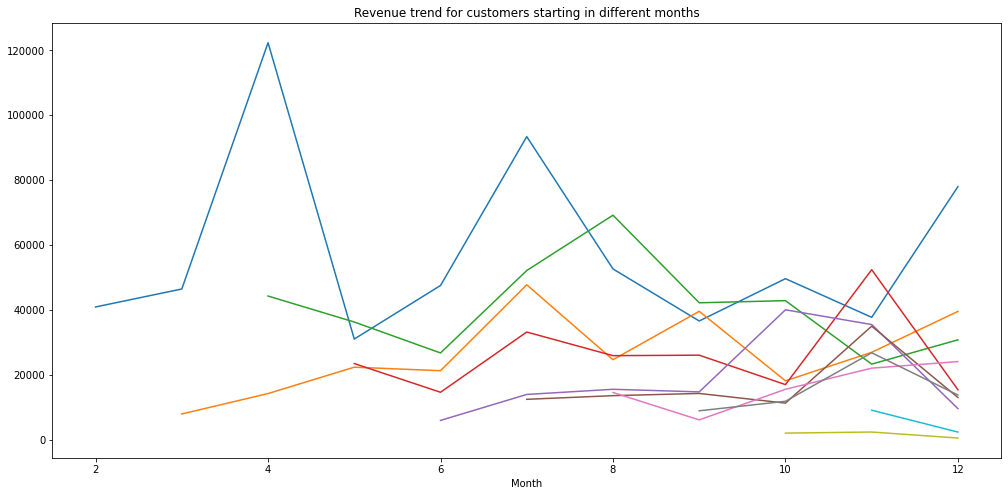

In [423]:
# Additional analysis for customers starting for different months
plt.figure(figsize=(17,8))
plt.title('Revenue trend for customers starting in different months')
for i in range(1,13):    
    a=sales[sales['Start_month']==i].groupby(by='Month').sum()['Invoice_amount']
    a[1:].plot(kind='line')


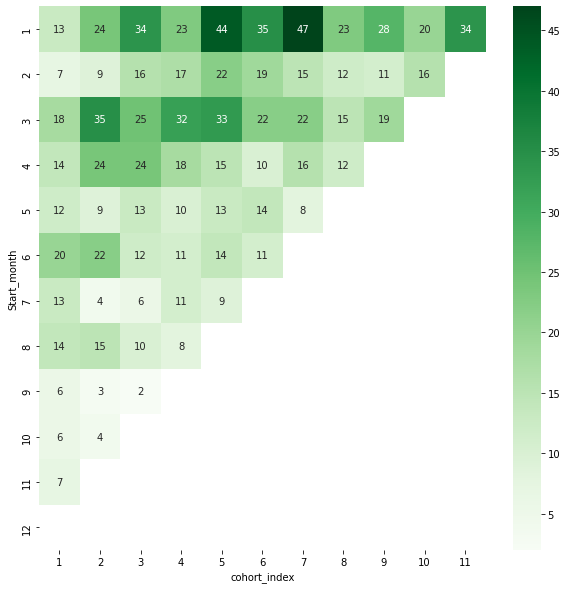

In [424]:
# Numbers of customer retented for each starting month for each cohert_index
plt.figure(figsize=(10,10))
sns.heatmap(sales.groupby(by=['Start_month','cohort_index'])['CustomerID'].nunique().unstack().loc[:,1:], annot=True, cmap='Greens')
plt.show()

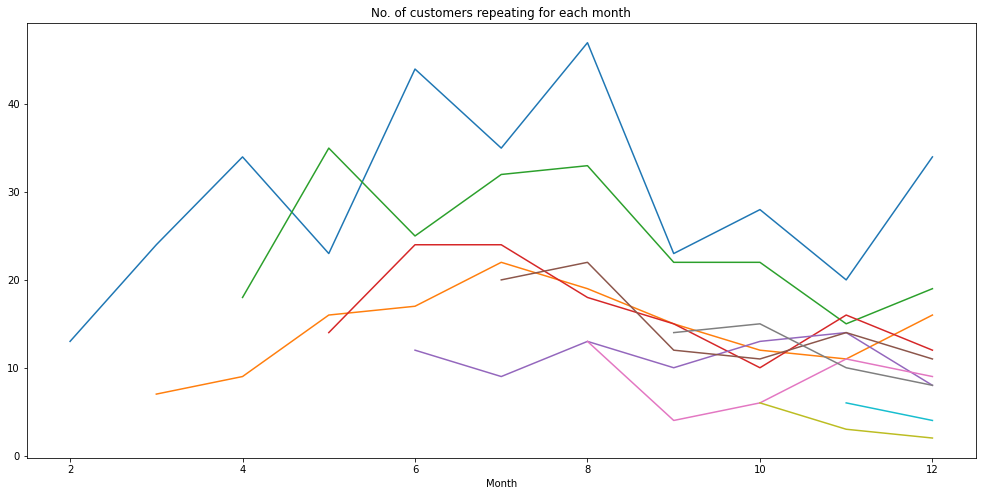

In [425]:

plt.figure(figsize=(17,8))
plt.title('No. of customers repeating for each month')
for i in range(1,13):    
    a=sales[sales['Start_month']==i].groupby(by='Month').nunique()['CustomerID']
    a[1:].plot(kind='line')
plt.show()

 • Which Month cohort has maximum retention?

In [426]:
# How many months most customers lasted??
sales.groupby(by=['Start_month','cohort_index'])['CustomerID'].nunique().unstack().sum()[1:]

cohort_index
1     130.0
2     149.0
3     142.0
4     130.0
5     150.0
6     111.0
7     108.0
8      62.0
9      58.0
10     36.0
11     34.0
dtype: float64

<AxesSubplot:xlabel='cohort_index'>

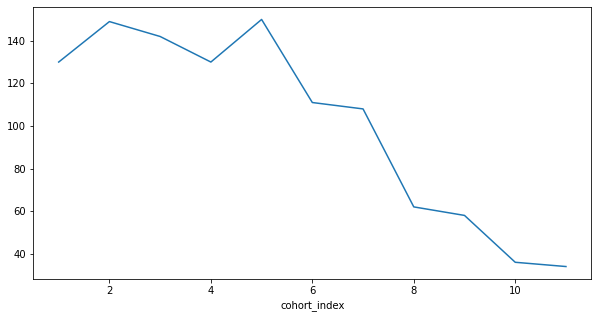

In [427]:
plt.figure(figsize=(10,5))
sales.groupby(by=['Start_month','cohort_index'])['CustomerID'].nunique().unstack().sum()[1:].plot()

In [428]:
# We can see that overall most customers stayed for
# 5 months- 150 customers
# 2 months- 149 customers
# 3 months- 142 customers

In [429]:
# Best retaining cohort_index for customer starting in each month
a=sales.groupby(by=['Start_month','cohort_index'])['CustomerID'].nunique().unstack().loc[:,1:]
best_cohort_index=pd.DataFrame()
b={}
for i in range(1,12):
    c=a[a.index==i][a[a.index==i]==a[a.index==i].max(axis=1)[i]].dropna(axis=1).columns.values.__getitem__(0)
    b[i]=[c]
best_cohort_index.rename(columns={0:'Best_cohort_index'}, inplace=True)

z=pd.DataFrame(b).T.reset_index()
z.rename(columns={'index':'Starting_month',0:'Best_retaining_index'}, inplace=True)
z.set_index('Starting_month', inplace=True)
display(z)

,Best_retaining_index
Starting_month,
1,7
2,5
3,2
4,2
5,6
6,2
7,1
8,2
9,1
